In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# export
import torch
from torch import nn
import torch.nn.functional as F
from typing import Dict, List
import enum
from enum import Enum

# Normalization and Denormalization

In [3]:
#export
class ChangeState(Enum):
    NORMALIZE=enum.auto(),
    DENORMALIZE=enum.auto(),
    OFF= enum.auto()
    
class ChangeImageStatsToKitti(nn.Module):
    SIGMA_MIN = 1e-5
    def __init__(self, direction: ChangeState):
        super().__init__()
        self.direction = direction
    
    def forward(self, x):
        if self.direction == ChangeState.NORMALIZE:
            return self._normalize(x)
        elif self.direction == ChangeState.DENORMALIZE:
            return self._denormalize(x)
        elif self.direction == ChangeState.OFF:
            return x
        else:
            raise ValueError(f'Invalid stats change direction {self.direction}')
    
    def _normalize(self, x):
        mean, var = self._get_stats()
        return (x - mean) / torch.sqrt(var + self.SIGMA_MIN)

    def _denormalize(self, x):
        mean, var = self._get_stats()
        return (x * torch.sqrt(var +  self.SIGMA_MIN5)) + mean
        
    @staticmethod
    def _get_stats():
        """Get mean and variance values of KITTI dataset."""
        # make mean, var into (3, 1, 1) so that they broadcast with NCHW
        mean = torch.nn.Parameter(
            torch.tensor([93.70454143384742, 98.28243432206516, 94.84678088809876],
                         dtype=torch.float32), requires_grad=False).unsqueeze(-1).unsqueeze(-1)
        var = torch.nn.Parameter(
            torch.tensor([5411.79935676, 5758.60456747, 5890.31451232],
                         dtype=torch.float32), requires_grad=False).unsqueeze(-1).unsqueeze(-1)
        return mean, var

# Padding



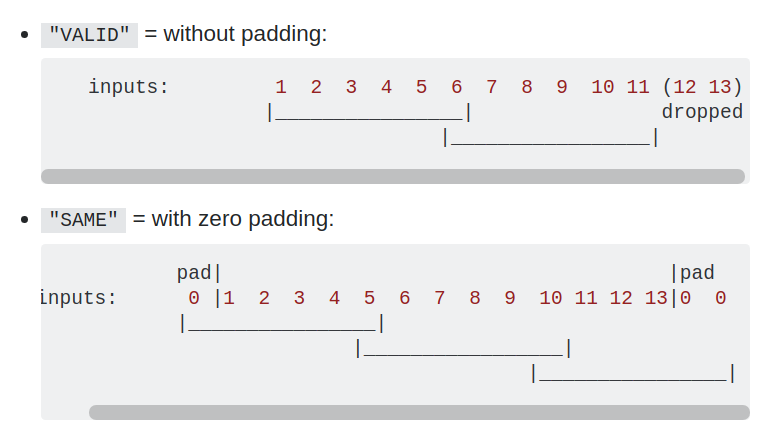In this example:

Input width = 13
Filter width = 6
Stride = 5
Notes:

- "VALID" only ever drops the right-most columns (or bottom-most rows).
- "SAME" tries to pad evenly left and right, but if the amount of columns to be added is odd, it will add the extra column to the right, as is the case in this example (the same logic applies vertically: there may be an extra row of zeros at the bottom).

About the name:

- With "SAME" padding, if you use a stride of 1, the layer's outputs will have the same spatial dimensions as its inputs.
- With "VALID" padding, there's no "made-up" padding inputs. The layer only uses valid input data.

Generally:
$$H_{out}=\lfloor\frac{H_{in}-d(k-1)+s-1}{stride}\rfloor$$

dilation = 1, stride = 1 :$$H_{out}=\lfloor\frac{H_{in}+2p-k+1}{stride}\rfloor$$ then p = k // 2 so that $$H_{out}=\lfloor\frac{H_{in}}{stride}\rfloor$$

dilation = 1, kernel = 5  stride = 2 :
$$H_{out}=\lfloor\frac{H_{in}+2p-3}{stride}\rfloor$$
I choose p= k// 2 = 2 ,  we need to verify that H remains divisable

dilation = 1, kernel = 3  stride = 2 :
$$H_{out}=\lfloor\frac{H_{in}+2p-1}{stride}\rfloor$$
I choose p= k// 2 = 1 ,  we need to verify that H remains divisable
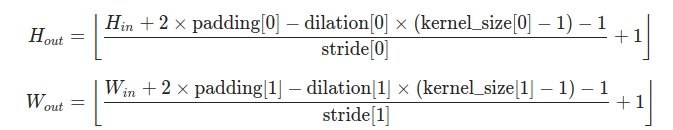

## TranspoeConv Padding
$$H_{out}=stride\times(H_{in}-1) + k - 2p $$

# Batch normalization

Videos by Andrew Ng
https://www.youtube.com/watch?v=nUUqwaxLnWs
https://www.youtube.com/watch?v=5qefnAek8OA

Transcription - https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c


In [4]:
# export
class Enc_Cs:
    """Consts for encoder"""
    in_channels_to_conv2d_1= 3
    n = 128
    quantizer_num_of_centers = 32
    use_heat_map = True
    
    basic_conv2d={'padding_mode':'replicate'}
    modifiable_conv2d={'conv':nn.Conv2d, **basic_conv2d}
    padding_stride2_kernel5={'kernel_size': [5,5],'stride': [2,2],'padding':[2,2]}
    padding_stride1_kernel3={'kernel_size': [3,3],'stride': [1,1],'padding':[1,1]}
    
    enc_conv2d_1={'in_channels': in_channels_to_conv2d_1,
                  'out_channels': n // 2,
                  **padding_stride2_kernel5,
                  **modifiable_conv2d}
    enc_conv2d_2={'in_channels': n // 2, 'out_channels': n,
                  **padding_stride2_kernel5,
                  **modifiable_conv2d}
    
    enc_resblock={'in_channels': n , 'out_channels': n,
                  **padding_stride1_kernel3,
                  **modifiable_conv2d}
    
    enc_uber_resblock={'num_of_resblocks':3, 'resblock':enc_resblock}
    enc_uber_resblocks={'num_of_uberresblocks': 5, 'uberresblock':enc_uber_resblock}
    
    last_conv2d_out =  \
        quantizer_num_of_centers + 1 if use_heat_map else quantizer_num_of_centers
    last_conv2d={'in_channels': n,
                 'out_channels': last_conv2d_out,
                  **padding_stride2_kernel5,
                  **basic_conv2d}
    
class Dec_Cs(Enc_Cs):
    def __init__(self):
        super().__init__()
        #override ```sself.basic_conv2d``` since nn.ConvTranspose2d cam padd only with zeros
        self.basic_conv2d={'padding_mode':'zeros'}
        #override ```self.modifiable_conv2d``` from nn.Conv2d to nn.ConvTranspose2d
        self.modifiable_conv2d={'conv':nn.ConvTranspose2d, **self.basic_conv2d}
        self.padding_stride2_kernel3={'kernel_size': [3,3],'stride': [2,2],'padding':[1,1]}
        self.conv2d_1 = {'in_channels': self.quantizer_num_of_centers,
                      'out_channels': self.n ,
                      **self.padding_stride2_kernel3,
                      **self.modifiable_conv2d}
        
        
        self.dec_resblock = {'in_channels': self.n , 'out_channels': self.n,
                  **self.padding_stride1_kernel3,
                  **super().modifiable_conv2d}
        self.dec_uber_resblock = {'num_of_resblocks': 3, 'resblock':self.dec_resblock}
        self.dec_uber_resblocks = {'num_of_uberresblocks': 5, 'uberresblock':self.dec_uber_resblock}
        
        self.dec_prelast_conv2d = {'in_channels': self.n , 'out_channels': self.n // 2,
                  **self.padding_stride2_kernel5,
                  **self.modifiable_conv2d}
        
        self.dec_last_conv2d = {'in_channels': self.n // 2 , 'out_channels': 3,
                  **self.padding_stride2_kernel5,
                  **self.basic_conv2d}

In [5]:
#export
class Encoder(nn.Module):
    def __init__(self,conv2d_1: Dict,
                      conv2d_2: Dict,
                      uberresblocks: Dict,
                      prelast_resblock: Dict,
                      last_conv2d: Dict):
        super().__init__()
        layers = [ChangeImageStatsToKitti(direction=ChangeState.NORMALIZE)]
        
        # first conv layers
        layers.extend([Conv2dReluBatch2d(**conv2d_1),
                       Conv2dReluBatch2d(**conv2d_2)])
        
        # 5 uber blocks
        for i in range(uberresblocks['num_of_uberresblocks']):
            layers.append(UberResBlock(**uberresblocks['uberresblock']))
            
        # resblock after the last uber-block
        layers.append(ResBlock(**prelast_resblock))
        self.pre_sum_model = nn.Sequential(*layers)
        
        self.post_sum_model= nn.Conv2d(**last_conv2d)
        
    @classmethod
    def create_module_from_const(cls):
        return cls(Enc_Cs.enc_conv2d_1,
                       Enc_Cs.enc_conv2d_2,
                       Enc_Cs.enc_uber_resblocks,
                       Enc_Cs.enc_uber_resblocks['uberresblock']['resblock'],
                       Enc_Cs.last_conv2d)
                      
                      
                      
    
    def forward(self, x):
        res_pre_conv = self.pre_sum_model(x) + x
        return self.post_sum_model(res_pre_conv)
    
class UberResBlock(nn.Module):
    
    def __init__(self,num_of_resblocks: int, resblock: Dict):
        super().__init__()
        layers = []
        for i in range(num_of_resblocks):
            layers.append(ResBlock(**resblock))
            
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x) + x

class ResBlock(nn.Module):
    NUM_OF_CONVS = 2 
    def __init__(self,in_channels: int, out_channels: int, kernel_size: List,
                 stride: List,padding_mode: str,padding, conv, num_of_convs: int = NUM_OF_CONVS):
        super().__init__()
        layers = []
        for i in range(num_of_convs):
            layers.append(conv(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    padding_mode=padding_mode,
                                    padding=padding))
            if i==0:
                layers.extend([nn.ReLU(),
                nn.BatchNorm2d(out_channels, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)])

        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x) + x
    
class Conv2dReluBatch2d(nn.Module):
    def __init__(self,in_channels: int, out_channels: int, kernel_size: List,
                 stride: List,padding_mode: str,padding, conv):
        super().__init__()
        
        
        self.model = nn.Sequential(conv(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    padding_mode=padding_mode,
                                    padding=padding),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_channels,
                                                  eps=1e-03,
                                                  momentum=0.1,
                                                  affine=True,
                                                  track_running_stats=True))
            
            
        
    def forward(self, x):
        return self.model(x)
    
    

In [6]:
enc = Encoder.create_module_from_const()
txt = 'Encoder(\n  (pre_sum_model): Sequential(\n    (0): ChangeImageStatsToKitti()\n    (1): Conv2dReluBatch2d(\n      (model): Sequential(\n        (0): Conv2d(3, 64, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)\n        (1): ReLU()\n        (2): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n      )\n    )\n    (2): Conv2dReluBatch2d(\n      (model): Sequential(\n        (0): Conv2d(64, 128, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)\n        (1): ReLU()\n        (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n      )\n    )\n    (3): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (4): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (5): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (6): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (7): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (8): ResBlock(\n      (model): Sequential(\n        (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n        (1): ReLU()\n        (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n        (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n      )\n    )\n  )\n  (post_sum_model): Conv2d(128, 33, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)\n)'
assert txt==repr(enc),"Encoder doesn't comply article"
print(enc)


Encoder(
  (pre_sum_model): Sequential(
    (0): ChangeImageStatsToKitti()
    (1): Conv2dReluBatch2d(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)
        (1): ReLU()
        (2): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv2dReluBatch2d(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2], padding_mode=replicate)
        (1): ReLU()
        (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): UberResBlock(
      (model): Sequential(
        (0): ResBlock(
          (model): Sequential(
            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
            (1): ReLU()
            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (3): Co

In [7]:
#export
class Decoder(nn.Module):
    def __init__(self,conv2d_1: Dict,
                      uberresblocks: Dict,
                      post_uberblock_resblock: Dict,
                      prelast_conv2d: Dict,
                      last_conv2d: Dict):
        super().__init__()
        layers = []
        
        # first deconv layers
        self.pre_uberblock_model = Conv2dReluBatch2d(**conv2d_1)
        
        # 5 uber blocks
        for i in range(uberresblocks['num_of_uberresblocks']):
            layers.append(UberResBlock(**uberresblocks['uberresblock']))
        # resblock after the last uber-block
        layers.append(ResBlock(**post_uberblock_resblock))
        self.pre_sum_model = nn.Sequential(*layers)
        
        self.post_sum_model= nn.Sequential(Conv2dReluBatch2d(**prelast_conv2d),
                                           nn.ConvTranspose2d(**last_conv2d),
                                           ChangeImageStatsToKitti(direction=ChangeState.DENORMALIZE))
        
    @classmethod
    def create_module_from_const(cls):
        consts = Dec_Cs()
        return cls(consts.conv2d_1,
                       consts.dec_uber_resblocks,
                       consts.dec_resblock,
                       consts.dec_prelast_conv2d,
                       consts.dec_last_conv2d)
                      
    
    def forward(self, x):
        pre_ubberblock = self.pre_uberblock_model(x)
        res_pre_conv = self.pre_sum_model(pre_ubberblock) + pre_ubberblock
        return self.post_sum_model(res_pre_conv)

In [8]:
dec = Decoder.create_module_from_const()

# test_decoder
txt= 'Decoder(\n  (pre_uberblock_model): Conv2dReluBatch2d(\n    (model): Sequential(\n      (0): ConvTranspose2d(32, 128, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])\n      (1): ReLU()\n      (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n    )\n  )\n  (pre_sum_model): Sequential(\n    (0): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (1): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (2): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (3): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (4): UberResBlock(\n      (model): Sequential(\n        (0): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (1): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n        (2): ResBlock(\n          (model): Sequential(\n            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n            (1): ReLU()\n            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n          )\n        )\n      )\n    )\n    (5): ResBlock(\n      (model): Sequential(\n        (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n        (1): ReLU()\n        (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n        (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)\n      )\n    )\n  )\n  (post_sum_model): Sequential(\n    (0): Conv2dReluBatch2d(\n      (model): Sequential(\n        (0): ConvTranspose2d(128, 64, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2])\n        (1): ReLU()\n        (2): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)\n      )\n    )\n    (1): ConvTranspose2d(64, 3, kernel_size=[5, 5], stride=[2, 2], padding=[2, 2])\n    (2): ChangeImageStatsToKitti()\n  )\n)'
assert repr(dec) == txt, "Decoder doesn't comply article"
print(dec)



Decoder(
  (pre_uberblock_model): Conv2dReluBatch2d(
    (model): Sequential(
      (0): ConvTranspose2d(32, 128, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
      (1): ReLU()
      (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pre_sum_model): Sequential(
    (0): UberResBlock(
      (model): Sequential(
        (0): ResBlock(
          (model): Sequential(
            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
            (1): ReLU()
            (2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (3): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
          )
        )
        (1): ResBlock(
          (model): Sequential(
            (0): Conv2d(128, 128, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1], padding_mode=replicate)
            (1): ReLU()
            (2): BatchNorm2d(12

# EXPORT

In [9]:
!python notebook2script.py nb__autoencoder_imgcomp.ipynb

Converted nb__autoencoder_imgcomp.ipynb to exp/autoencoder_imgcomp.py
